<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_numerical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Diffusion equation

In this project we will use several methods to solve the diffusion equation:

$$ \partial_t c = \kappa \partial_x^2 c $$

This project consists of two notebooks. First, in this notebook, we will solve this equation using second order finite differences to approximate the $x$-derivatives, and we will use both the explict Euler and Crank-Nicolson timestepping methods.

In the second notebook for this project, we will learn how to use Dedalus to solve the same problem using spectral methods.

The objective for this notebook is learn about spatial discretization and to compare the stability, accuracy, and speed of the Explicit euler and Crank-Nicolson methods when applied to the diffusion equation.

Student tasks are in [Section 2.1](#section2pt1) and [Section 2.2](#section2pt2).

Before we start, load in the required libraries

In [1]:
# Importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import time

from matplotlib import rc 
plt.style.use("ggplot")
rc('font',**{'family':'Source Sans 3','weight':'normal','size':'10'})




Now, define two functions to timestep the diffusion equation. The code below timesteps the diffusion equation using the expicit Euler method. The function takes in a vector of discrete positions, `x`, discrete times, `t`, and the diffusivity, `kappa`. The vectors `x` and `t` dictate the discretization of the problem in space and time, and the grid spacing must be constant in space and time. The boundary conditions are $\partial_x c=0$ at the starting and ending points in `x`.

In [2]:
def EE(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods

    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # Builds a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed
    M = sp.csr_matrix(M)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt):  # loop over the number of timesteps
      c[:,k] = c[:,k-1] + dt * kappa * M @ c[:,k-1]
      # Enforce the boundary conditions (no flux)
      c[0, k] = c[1, k]
      c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Explicit Euler method took {end_time - start_time:.2f} seconds")

    return c

Similarly, the function below timesteps the diffusion equation with the Crank-Nicolson method

In [3]:
def CN(x, t, kappa):
# This function timesteps the diffusion equation with homogeneous Neumann boundary conditions
# using the explicit Euler and second order finite difference methods
    start_time = time.time()  # Start a timer

    # Infer the uniform grid spacing:
    dx = (x[-1] - x[0]) / (len(x) - 1); dt = (t[-1] - t[0]) / (len(t) - 1)

    # Set the number of gridpoints in x and t
    Nx = len(x); Nt = len(t)

    # build a coefficient matrix, such that M*c is the discrete version of d/dx(c)
    M = (np.diag(np.ones(Nx-1), -1) - 2*np.diag(np.ones(Nx), 0) + np.diag(np.ones(Nx-1), 1)) / dx**2

    # Turn M into a sparse matrix to save memory and improve speed:
    M = sp.csr_matrix(M)

    A = sp.eye(Nx) - 0.5 * dt * kappa * M  # This matrix appears on the LHS in the C-N scheme
    A_inv = spla.inv(A) # Calculate the inverse of A (this only needs to be done once)

    # Create an empty sparse array to store the solution
    c = np.zeros((Nx, Nt))

    c[:, 0] = set_ics(x, kappa, 10)  # Set the initial condition

    for k in range(1, Nt): # loop over the number of timesteps
        c[:, k] = A_inv @ (c[:, k-1] + 0.5 * dt * kappa * (M @ c[:, k-1]))
        # Enforce the boundary conditions
        c[0, k] = c[1, k]
        c[-1, k] = c[-2, k]

    end_time = time.time()  # Print the elapsed time

    # print(f"Crank-Nicolson method took {end_time - start_time:.2f} seconds")

    return c

Next, create a function to set the initial conditions. The exact solution to the unbounded diffusion equation with a delta function initial condition is:

$$\left(\frac{1}{4\pi\kappa t}\right)^{1/2}e^{-x^2/(4\kappa t)}$$

The function below sets the initial condition by evaluating the exact solution at a given time. Note that it is important that we don't evaluate the exact solution at `t_ic=0` since this will return a delta function which will be undefined on our finite grid. The value of `t_ic` is set within the `EE` and `CN` functions.

In [4]:
# Function to set the initial condition from the exact solution at time t_start
def set_ics(x, kappa, t_ic):
    c_ic = (4*np.pi*kappa*t_ic)**(-0.5)*np.exp(-x**2 / (4*kappa*t_ic))
    # Enforce the boundary conditions
    c_ic[0] = c_ic[1]
    c_ic[-1] = c_ic[-2]
    return c_ic


Finally, define some parameters and the x and t vectors:

In [5]:
# Defining parameters
kappa = 0.001  # diffusivity

# Timestepping parameters
t_start = 0  # start time (note that this is not the same time used to evaluate the exact solution to set the ICs)
t_end = 10  # end time
Nt = 1000  # number of timesteps

# Size of the physical domain
x_start = -1
x_end = 1
Nx = 100

t = np.linspace(t_start, t_end, Nt)  # Create a vector of times
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

Run each method once:

In [6]:
# Run the simulations
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

/home/sam0fc/miniconda3/envs/dedalus/lib/python3.13/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/sam0fc/miniconda3/envs/dedalus/lib/python3.13/site-packages/scipy/sparse/linalg/_matfuncs.py:76: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  Ainv = spsolve(A, I)


and finally, plot the results side-by-side

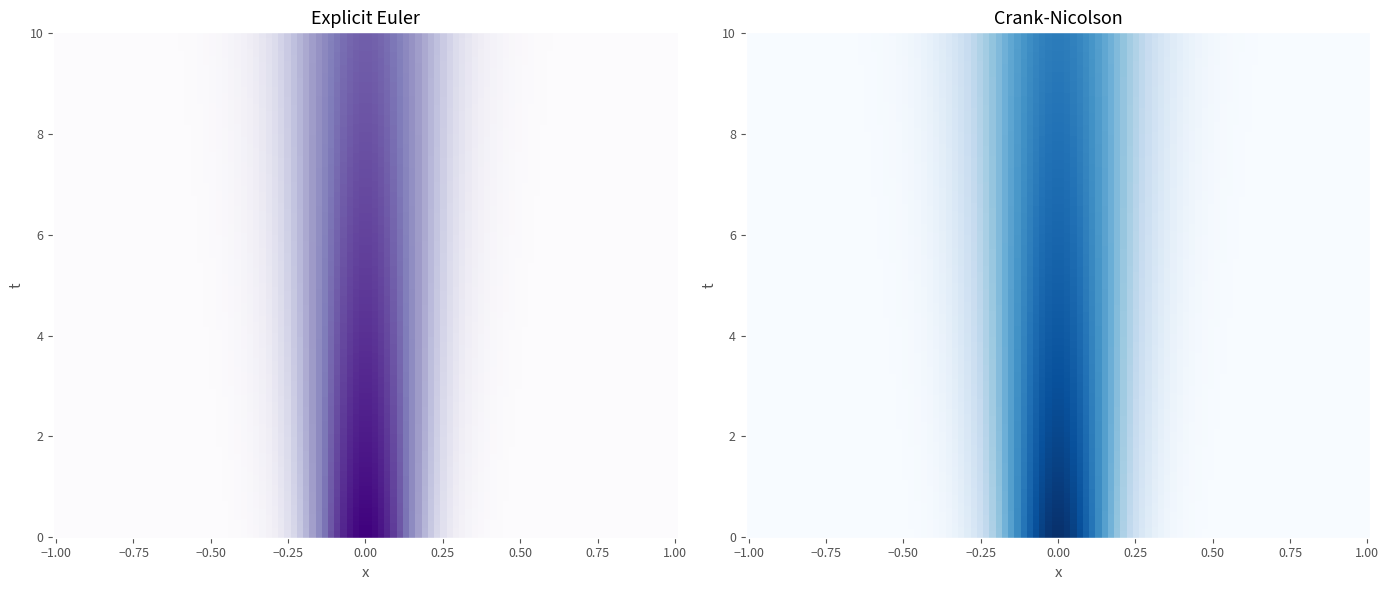

In [7]:
# Plot the results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.pcolormesh(x, t, c_EE.T, shading='auto',cmap = cm.Purples)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Explicit Euler')

plt.subplot(1, 2, 2)
plt.pcolormesh(x, t, c_CN.T, shading='auto',cmap=cm.Blues)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Crank-Nicolson')

plt.tight_layout()
plt.show()

## 2. Student investigation

### 2.1 Stability
<a id='section2pt1'></a>
The explicit Euler and Crank-Nicolson methods have very different stability properties. To explore this, try increasing Nx (decreasing the grid spacing, $\Delta x$) and/or increase the diffusivity, $\kappa$, and see how each method responds. How does the stability depend on `Nx`? Discuss your findings below (~1 paragraph)

**Non-dimensionalising the diffusion equation, we find a number in the form $\frac{\kappa T}{L^2}$, where $L$ is the non dimensional lengthscale associated with $x$, and $T$ with $t$, i.e. the Fourier Number with a characteristic length scale. By using the step size $\Delta t$ and $\Delta x$ as the characteristic scales, this provides a parameter ($r$), which can be used to evaluate the stability. At $r$ just larger than $1/2$, the Explicit Euler method becomes unstable, whereas the Crank-Nicolson method is stable for all values of $r$ (though at large x step sizes you cannot resolve the solution!).**

**At sufficiently small $\Delta x$, i.e. larger Nx s.t. $r>\frac{1}{2}$, the stability of Explicit Euler breaks down, meaning that the errors will grow and be carried forward as there is error generated by a large time step relative to the spatial resolution. In the general case, Von Neumann analysis yields that in order for the heat equation to be numerically stable, $r<\frac 12$. This is relatively close to the 0.51 we see numerically, probably due to the fact that some errors are being propagated, but not enough to demonstrate instability on the domain.**

**The difference is mainly that as an explicit method, we calculate the derivative based on two values of the function, which means that for sufficiently large timesteps, the error created by the change in the derivative is large enough that the approximation stops being bounder on the domain.** 

**As Nx increases for constant delta t, the method becomes more stable, as $x\propto\frac{1}{r^2}$**.

[447, 0.01, 0.4995225000000001]
[451, 0.01, 0.5085025000000001]
[452, 0.01, 0.5107600000000001]
[456, 0.01, 0.5198400000000001]


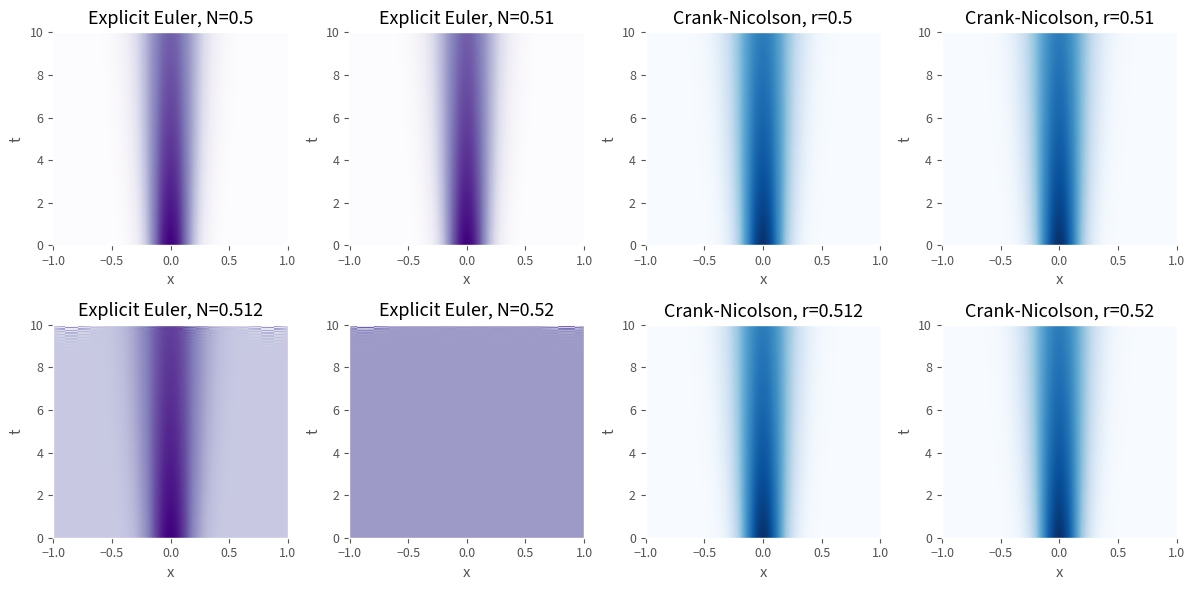

In [8]:
# make a series of subplots with different values for our non dimensional parameter by varying Nx.

fig, axs = plt.subplots(2, 4, figsize=(12,6))
kappa = 0.001
Nt = 1000
t = np.linspace(t_start, t_end, Nt)  # Create a vector of time
delta_t = (t_end - t_start)/Nt

for n, parameter_r in enumerate([0.50,0.51,0.512,0.52]):
    delta_x = (kappa *delta_t / parameter_r)**(1/2) #calculare the grid spacing based on our parameter
    Nx = int((x_end - x_start)/delta_x)
    x = np.linspace(x_start, x_end, Nx)  # Create a vector for x

    c_EE = EE(x, t, kappa) # explicit Euler
    c_CN = CN(x, t, kappa) # Crank-Nicolson

    ax = axs[n//2, n%2]
    ax.pcolormesh(x, t, c_EE.T, shading='auto',cmap=cm.Purples)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title(f'Explicit Euler, N={parameter_r:}')

    ax= axs[n//2, n%2 + 2]
    ax.pcolormesh(x, t, c_CN.T, shading='auto',cmap=cm.Blues)
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title(f'Crank-Nicolson, r={parameter_r}')
    print([Nx,delta_t, kappa * delta_t / ((x_end-x_start)/Nx)**2]) # Print actual value of the Nx and parameter r after floating point gets rid of our precision
plt.tight_layout()


### 2.2 Accuracy
<a id='section2pt2'></a>
Next, we will examine the accuracy of the numerical methods used above. In order to do this, it is useful to compare our numerical solutions with the exact solution to the diffusion equation. Below, write code to plot the exact solution and the numerical solution using explicit Euler and Crank-Nicolson at the final time ($t=10$). Note that you can use the exact solution to the diffusion equation in an unbounded domain in $x$ and keep in mind that the exact solution and numerical solutions will differ for later times when boundary effects are felt.

200


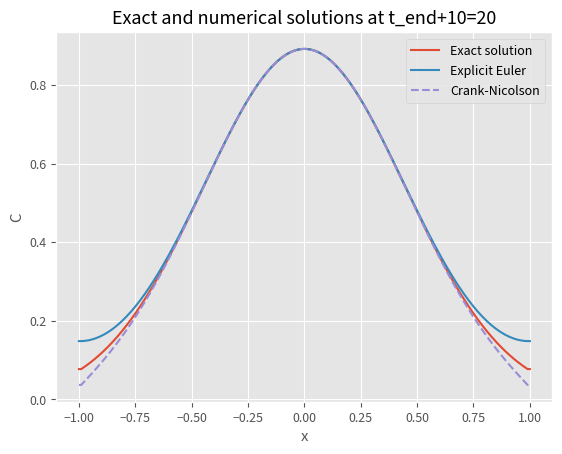

In [9]:
# Add code to plot exact and numerical solutions
t_end = 10
kappa = 0.005 #making kappa large to show the errors between the methods
Nt = 1000
t = np.linspace(t_start, t_end, Nt)  # Create a vector of time

delta_t = (t_end - t_start)/Nt
parameter_r = 0.5
delta_x = (kappa * delta_t / parameter_r)**(1/2) #calculare the grid spacing based on our parameter

Nx = int((x_end - x_start)/delta_x)
print(Nx)
x = np.linspace(x_start, x_end, Nx)  # Create a vector for x


exact_solution = set_ics(x, kappa, t_end+10)
c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson



plt.plot(x, exact_solution, label='Exact solution')

plt.plot(x, c_EE[:, -1], label='Explicit Euler')

plt.plot(x, c_CN[:, -1], label='Crank-Nicolson', linestyle='dashed')

#labels
plt.legend()
plt.xlabel('x')
plt.ylabel('C')
plt.title(f'Exact and numerical solutions at {t_end+10=}')
plt.show()

Now, define a measure of the error of each numerical method compared to the exact solution (there is no single correct way to do this). Plot the error of both methods as a function of the grid spacing $\Delta x$. Then, similarly plot the error as a function of the timestep, $\Delta t$.

DISCUSS DEFINITION OF ERROR

**I've defined my error below as the Euclidean distance between the two solution vectors. This, I believe, is reasonable as the size of all the components are relatively similar, and the intuition of distance away seems a reasonable measure of error. It also gives a single value for the error, and can be applied to one timestep or to the whole solution field.**

**Notably, a different measure of error may be justified for early times, as the exact solution's delta function causes it to go to infinity as time approaches zero. I considered using the Manhattan distance between the vectors for more robustness against outliers, but decided that the smoothness of the function, the geometric intuition, and the fact that the first numerical step is 10 seconds after the delta function, means that the emphasis on larger deviations by the Euclidean distance is more valid.**

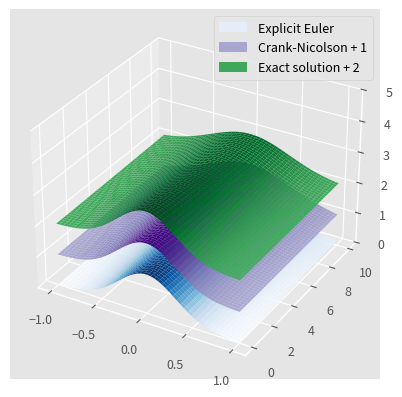

In [10]:
# Add code to plot error here
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
tt,xx = np.meshgrid(t,x)

def calculate_soln_grid(x,t,kappa):
    exact_solution = np.zeros((len(x), len(t)))
    for index, timestep in enumerate(t):
        if timestep !=0:
            exact_solution[ : , index] = set_ics(x, kappa, timestep+10)
        if timestep ==0: #set the initial condition
            exact_solution[ : , index] = set_ics(x, kappa, t[index+1]+10)
    return exact_solution

exact_solution = calculate_soln_grid(x,t,kappa)

c_EE = EE(x, t, kappa) # explicit Euler
c_CN = CN(x, t, kappa) # Crank-Nicolson

ax.plot_surface(xx,tt,c_EE, vmin=c_EE.min() * 2, cmap=cm.Blues)
ax.plot_surface(xx,tt,c_CN+1, vmin=c_CN.min() * 2, cmap=cm.Purples)
ax.plot_surface(xx,tt,exact_solution+2, vmin=exact_solution.min() * 2, cmap=cm.Greens)
ax.legend(['Explicit Euler', 'Crank-Nicolson + 1', 'Exact solution + 2'])
ax.set_zbound(0,5)

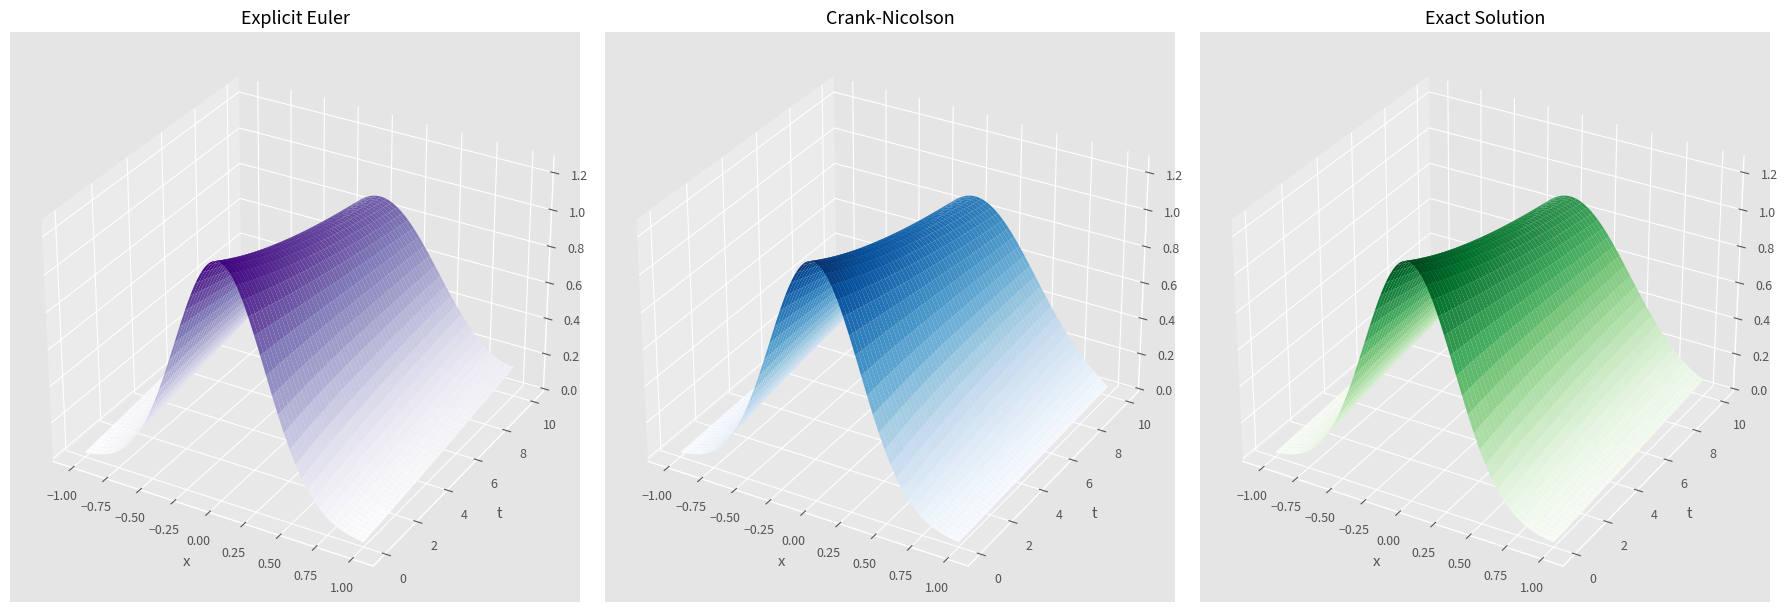

In [11]:
# Plot the results
fig, axs = plt.subplots(1, 3, figsize=(18, 6),subplot_kw={"projection": "3d"})

# Plot Explicit Euler method
axs[0].plot_surface(xx, tt, c_EE, cmap=cm.Purples)
axs[0].set_xlabel('x')
axs[0].set_ylabel('t')
axs[0].set_title('Explicit Euler')

# Plot Crank-Nicolson method
axs[1].plot_surface(xx, tt, c_CN, cmap=cm.Blues)
axs[1].set_xlabel('x')
axs[1].set_ylabel('t')
axs[1].set_title('Crank-Nicolson')

# Plot Exact solution
axs[2].plot_surface(xx, tt, exact_solution, cmap=cm.Greens)
axs[2].set_xlabel('x')
axs[2].set_ylabel('t')
axs[2].set_title('Exact Solution')

plt.tight_layout()
plt.show()

In [12]:
def calculate_error(c, exact_solution):
    return np.linalg.norm(c - exact_solution) #use the euclidean norm as a proxy for error

exact_solution_clipped =exact_solution[:,10:]
c_EE_clipped = c_EE[:,10:]
c_CN_clipped = c_CN[:,10:]
error_EE = calculate_error(c_EE_clipped, exact_solution_clipped)
error_CN = calculate_error(c_CN_clipped, exact_solution_clipped)
print(f"{error_EE=}, {error_CN=}")

error_EE=np.float64(5.482445760830199), error_CN=np.float64(2.8233748339513527)


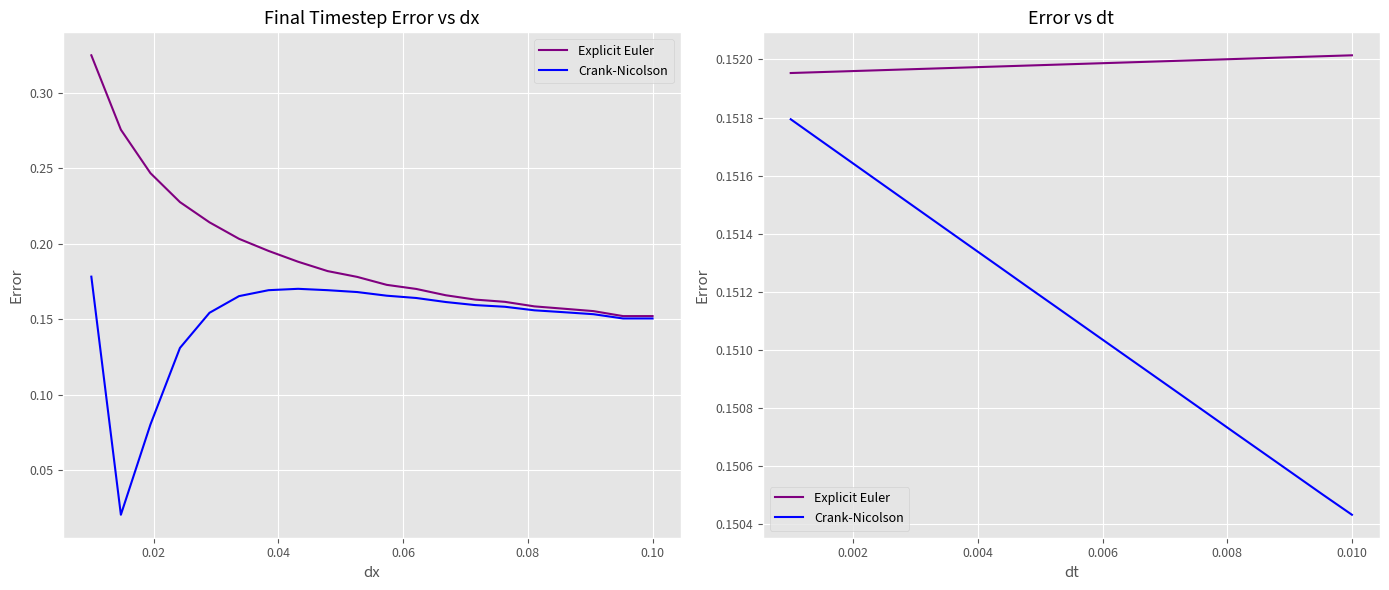

In [13]:
# plot the error at the final timestep as a function of dx
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot error as a function of dx
dx_values = np.linspace(0.01, 0.1, 20)
error_values_dx = []
for dx in dx_values:
    Nx = int((x_end - x_start) / dx)
    x = np.linspace(x_start, x_end, Nx)  # Create a vector for x
    c_CN = CN(x, t, kappa)  # Crank-Nicolson
    c_EE = EE(x, t, kappa)  # explicit Euler
    error_EE = calculate_error(c_EE[:, -1], set_ics(x, kappa, t_end+10))
    error_CN = calculate_error(c_CN[:, -1], set_ics(x, kappa, t_end+10))
    error_values_dx.append((error_EE, error_CN))

error_values_dx = np.array(error_values_dx)
ax1.plot(dx_values, error_values_dx[:, 0], label='Explicit Euler',color='purple')
ax1.plot(dx_values, error_values_dx[:, 1], label='Crank-Nicolson',color='blue')
ax1.set_xlabel('dx')
ax1.set_ylabel('Error')
ax1.legend()
ax1.set_title('Final Timestep Error vs dx')

# Plot error as a function of dt
dt_values = np.linspace(0.001, 0.01, 20)
error_values_dt = []
for dt in dt_values:
    Nt = int((t_end - t_start) / dt)
    t = np.linspace(t_start, t_end, Nt)  # Create a vector of time
    c_CN = CN(x, t, kappa)  # Crank-Nicolson
    c_EE = EE(x, t, kappa)  # explicit Euler
    error_EE = calculate_error(c_EE[:, -1], set_ics(x, kappa, t_end+10))
    error_CN = calculate_error(c_CN[:, -1], set_ics(x, kappa, t_end+10))
    error_values_dt.append((error_EE, error_CN))

error_values_dt = np.array(error_values_dt)
ax2.plot(dt_values, error_values_dt[:, 0], label='Explicit Euler',color='purple')
ax2.plot(dt_values, error_values_dt[:, 1], label='Crank-Nicolson',color='blue')
ax2.set_xlabel('dt')
ax2.set_ylabel('Error')
ax2.legend()
ax2.set_title('Error vs dt')

plt.tight_layout()

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# Define a function to calculate the error at the final timestep
def calculate_final_timestep_error(dx, dt, kappa, t_end, x_start, x_end):
    Nx = int((x_end - x_start) / dx)
    Nt = int(t_end / dt)
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(0, t_end, Nt)
    exact_solution = set_ics(x, kappa, t_end+10)
    c_EE = EE(x, t, kappa)
    c_CN = CN(x, t, kappa)
    error_EE = calculate_error(c_EE[:, -1], exact_solution)
    error_CN = calculate_error(c_CN[:, -1], exact_solution)
    return error_EE, error_CN

# Define ranges for dx and dt
dx_values = np.linspace(0.01, 0.1, 20)
dt_values = np.linspace(0.001, 0.01, 20)

# Calculate errors for each combination of dx and dt
errors_EE = np.zeros((len(dx_values), len(dt_values)))
errors_CN = np.zeros((len(dx_values), len(dt_values)))

for i, dx in enumerate(dx_values):
    for j, dt in enumerate(dt_values):
        error_EE, error_CN = calculate_final_timestep_error(dx, dt, kappa, t_end, x_start, x_end)
        errors_EE[i, j] = error_EE
        errors_CN[i, j] = error_CN


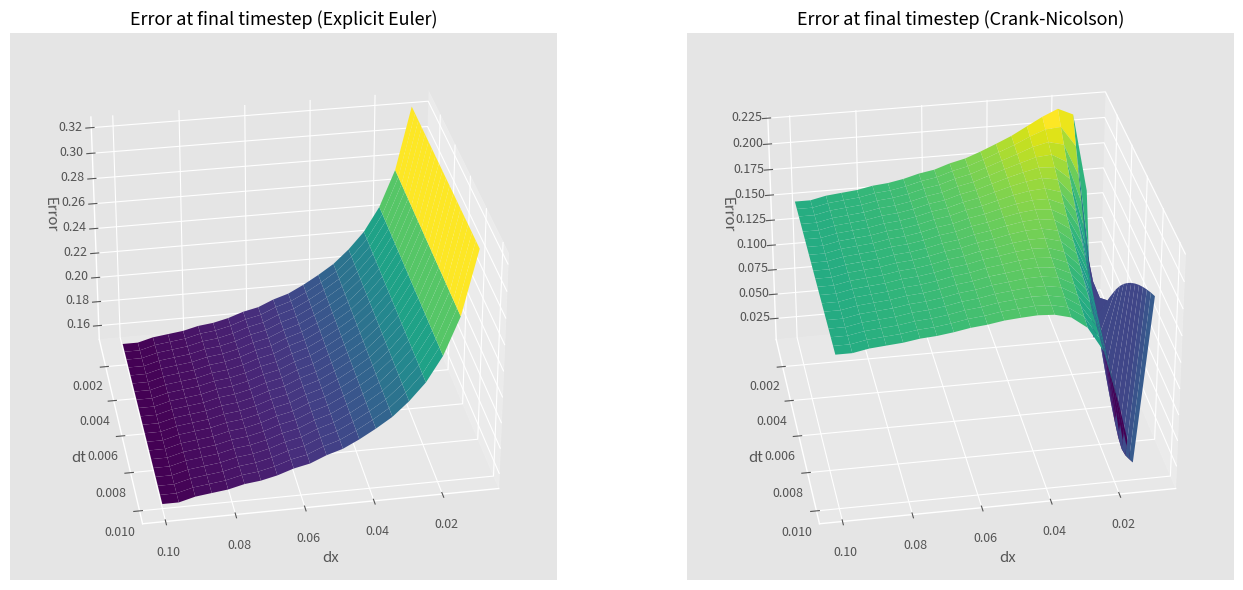

In [15]:

# Create a meshgrid for plotting
DX, DT = np.meshgrid(dx_values, dt_values)

# Plot the surface for Explicit Euler
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(DX, DT, errors_EE.T, cmap='viridis')
ax.set_xlabel('dx')
ax.set_ylabel('dt')
ax.set_zlabel('Error')
ax.set_title('Error at final timestep (Explicit Euler)')
ax.view_init(elev=30, azim=80)

# Plot the surface for Crank-Nicolson
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(DX, DT, errors_CN.T, cmap='viridis')
ax.set_xlabel('dx')
ax.set_ylabel('dt')
ax.set_zlabel('Error')
ax.set_title('Error at final timestep (Crank-Nicolson)')

ax.view_init(elev=30, azim=80)

plt.tight_layout()
plt.show()

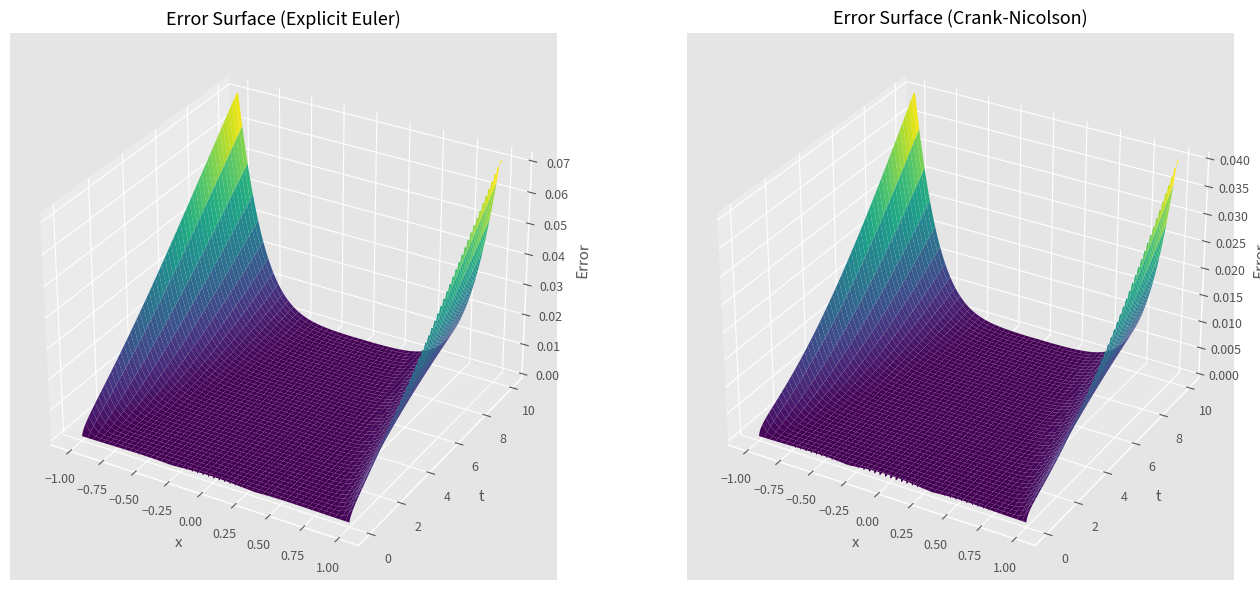

In [16]:
# Define x and t
x = np.linspace(-1, 1, 200)
t = np.linspace(0, 10, 1000)
Nx = len(x)
Nt = len(t)
# Recalculate the exact solution for the entire x-t grid
exact_solution_grid = calculate_soln_grid(x,t,kappa)
# Recalculate the two methods
c_EE = EE(x, t, kappa)  # explicit Euler
c_CN = CN(x, t, kappa)  # Crank-Nicolson

# Calculate the error at each point in the x-t grid for both methods
error_surface_EE = np.abs(c_EE - exact_solution_grid)
error_surface_CN = np.abs(c_CN - exact_solution_grid)

# Create a meshgrid for plotting
xx, tt = np.meshgrid(x, t)

# Plot the error surface for Explicit Euler
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(xx, tt, error_surface_EE.T, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Error')
ax.set_title('Error Surface (Explicit Euler)')

# Plot the error surface for Crank-Nicolson
ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(xx, tt, error_surface_CN.T, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Error')
ax.set_title('Error Surface (Crank-Nicolson)')

plt.tight_layout()
plt.show()

**Error appears to be dominated by boundary conditions at late times.**

In [17]:
# Define x and t
x = np.linspace(-1, 1, 200)
t = np.linspace(0, 10, 1000)
Nx = len(x)
Nt = len(t)
# Recalculate the exact solution for the entire x-t grid
exact_solution_grid = calculate_soln_grid(x,t,kappa)
# Recalculate the two methods
c_EE = EE(x, t, kappa)  # explicit Euler
c_CN = CN(x, t, kappa)  # Crank-Nicolson

# Calculate the error using Euclidean distance for c_CN and c_EE with the exact solution
error_CN_euclidean = np.linalg.norm(c_CN - exact_solution_grid)
error_EE_euclidean = np.linalg.norm(c_EE - exact_solution_grid)

print(f"Euclidean distance error for Crank-Nicolson: {error_CN_euclidean}")
print(f"Euclidean distance error for Explicit Euler: {error_EE_euclidean}")

Euclidean distance error for Crank-Nicolson: 2.8233820598184654
Euclidean distance error for Explicit Euler: 5.482453463408522


Finally, select a given error tolerance and explore whether explicit Euler or Crank-Nicoslon is more efficient (faster) at generating solutions with error less than your error tolerance. Discuss your conclusion and add supporting figures if necessary.

INSERT DISCUSSION OF ERROR HERE (~1 paragraph).  OPTIONALLY ADD PLOTS BY INSERTING A CODE BLOCK BELOW.

In [18]:
import time
def calculate_error_over_time(c, exact_solution):
    return np.linalg.norm(c - exact_solution)

# Function to calculate the error over all time
def calculate_total_error(dx, dt, kappa, t_end, x_start, x_end, method):
    Nx = int((x_end - x_start) / dx)
    Nt = int(t_end / dt)
    x = np.linspace(x_start, x_end, Nx)
    t = np.linspace(0, t_end, Nt)
    exact_solution = calculate_soln_grid(x,t,kappa)

    error_CN = None
    error_EE = None

    if method == 'EE' or method == 'both':
        c_EE = EE(x, t, kappa)
        error_EE = calculate_error_over_time(c_EE, exact_solution)
    if method == 'CN' or method == 'both':
        c_CN = CN(x, t, kappa)
        error_CN = calculate_error_over_time(c_CN, exact_solution)
    if method == 'EE':
        return error_EE
    elif method == 'CN':
        return error_CN
    elif method == 'both':
        return error_EE, error_CN
    

# Define ranges for dx and dt
dx_values = np.linspace(0.01, 0.1, 20)
dt_values = np.linspace(0.001, 0.01, 20)

# Initialize variables to store the best parameters and errors
best_dx = None
best_dt = None
best_error_EE = float('inf')
best_error_CN = float('inf')

# Ensure the best parameters are less than 5
for dx in dx_values:
    for dt in dt_values:
        error_EE, error_CN = calculate_total_error(dx, dt, kappa, t_end, x_start, x_end, 'both')
        if error_EE < 5 and abs(error_EE - 5) < abs(best_error_EE - 5):
            best_dx_EE = dx
            best_dt_EE = dt
            best_error_EE = error_EE
        if error_CN < 5 and abs(error_CN - 5) < abs(best_error_CN - 5):
            best_dx_CN = dx
            best_dt_CN = dt
            best_error_CN = error_CN

# Print the best parameters and errors
print(f"Params closest to error 5 for Explicit Euler: dx={best_dx_EE}, dt={best_dt_EE}, error={best_error_EE}")
print(f"Params closest to error 5 for Crank-Nicolson: dx={best_dx_CN}, dt={best_dt_CN}, error={best_error_CN}")

# Time the final run with the best parameters
start_time = time.time()
error_EE = calculate_total_error(best_dx_EE, best_dt_EE, kappa, t_end, x_start, x_end, 'EE')
end_time = time.time()

# Print the elapsed time
print(f"Elapsed time for EE run: {end_time - start_time:.2f} seconds")


start_time = time.time()
error_CN = calculate_total_error(best_dx_CN, best_dt_CN, kappa, t_end, x_start, x_end, 'CN')
end_time = time.time()

# Print the elapsed time
print(f"Elapsed time for CN run: {end_time - start_time:.2f} seconds")

Params closest to error 5 for Explicit Euler: dx=0.0668421052631579, dt=0.003368421052631579, error=4.960312445809458
Params closest to error 5 for Crank-Nicolson: dx=0.04789473684210527, dt=0.003842105263157895, error=4.9326769826932235
Elapsed time for EE run: 0.09 seconds
Elapsed time for CN run: 0.05 seconds


# Error Discussion
**Crank-Nicolson was significantly faster with an error tolerance of 5. It was able to manage a smaller step size in dx with a comparable (though larger) size of dt. Consistently, CN has been able to produce less errors and is more stable. I assume this is because it takes into account a future term, therefore the extension of the previous derivative (as in Euler's method) cannot produce a gradually increasing error which could generate spikes or oscillations.**  

In [19]:
print(f"{error_CN=}, {error_EE=}")

error_CN=np.float64(4.9326769826932235), error_EE=np.float64(4.960312445809458)


Now, move to Project1_dedalus.ipynb which will introduce Dedalus and spectral methods.

### 3. Optional further investigations

The application of the boundary conditions for the Crank-Nicolson method isn't quite right in the script above (but the boundary conditions aren't very important in this example). Account for the boundary conditions by modifying the coefficient matrix. This ensures that the boundary conditions are applied to the implicit and explicit terms involved in the Crank-Nicolson update. How would you handle fixed value (Dirichlet) and fixed gradient (Neumann) boundary conditions?